# Libraries and Utilities

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Data Properties

In [ ]:
df = pd.read_csv("reddit_wsb.csv")
df['date'] = df['timestamp'].apply(lambda x: str(x).split(" ")[0].split("-")[0:2])
df['time'] = df['timestamp'].apply(lambda x: str(x).split(" ")[1])
df = df.drop(['id', 'url', 'created', 'timestamp'], axis=1)

In [ ]:
df.head()

,title,score,comms_num,body,date,time
0,"It's not about the money, it's about sending a...",55,6,NaN,"[2021, 01]",21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,"[2021, 01]",21:32:10
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,"[2021, 01]",21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,"[2021, 01]",21:28:57
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,"[2021, 01]",21:26:56


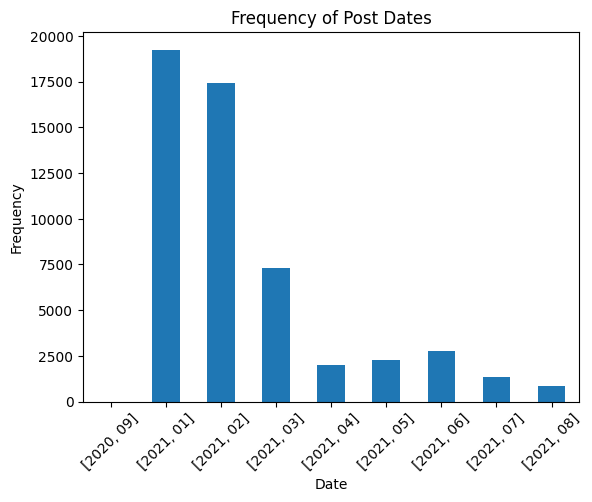

In [ ]:
df['date'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of Post Dates')
plt.xticks(rotation=45)
plt.show()
# we can see that the majority of posts occur in 2021 onwards in this dataset, with most in the months of jan and feb
# caused by the influx of new users to the platform about this time from the gamestop shortsqueeze event

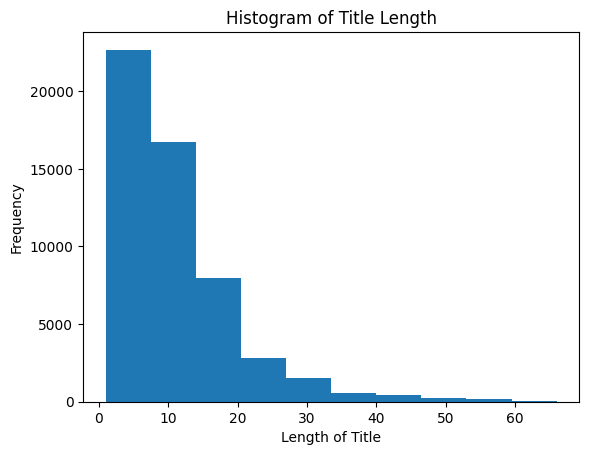

In [ ]:
lengths = df['title'].apply(lambda x : len(x.split(' ')))
plt.hist(lengths)
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.title("Histogram of Title Length")
plt.show()

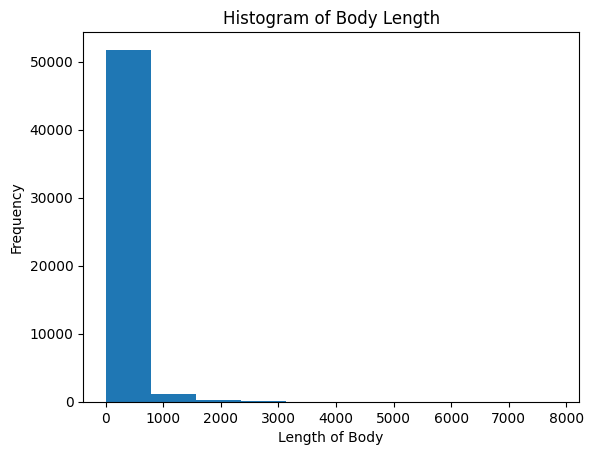

In [ ]:
lengths = df['body'].apply(lambda x : len(str(x).split(' ')))
plt.hist(lengths)
plt.xlabel('Length of Body')
plt.ylabel('Frequency')
plt.title("Histogram of Body Length")
plt.show()

# Data Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
title_data = df[['title','timestamp']].copy()
body_data = df[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()

title_data.title =title_data.title.str.lower()
body_data.body =body_data.body.str.lower()

#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# Remove Time From Timestamp
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

#reset index of these values
title_data = title_data.reset_index()
body_data = body_data.reset_index()

In [ ]:
def remove_stop(x):
  word_tokens = word_tokenize(x)
  output = [w for w in word_tokens if not w.lower() in stop_words]
  string = " "
  string = string.join(output)
  return string[:2500]

# capping this at 2500 characters given the sentiment analysis library

In [ ]:
title_data['new_title'] = title_data['title'].apply(lambda x: remove_stop(x))

In [ ]:
body_data['new_body'] = body_data['body'].apply(lambda x: remove_stop(x))

In [ ]:
# we can that by removing rows of text with na values, there are half as many body elements as the title

# Semantic Analysis

In [ ]:
# getting financial sentiment of the posts title and body we find postive, neutral, and negative scores for the posts
# this will allow us to see the posts opinion on the market in question

In [ ]:
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

In [ ]:
def predict_sentiment(text):
  inputs = tokenizer(text, return_tensors="pt", max_length=1022, truncation=True)
  outputs = model(**inputs)
  sentiment_class = outputs.logits.argmax(dim=1).item()
  sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
  predicted_sentiment = sentiment_mapping.get(sentiment_class, 'Unknown')
  return predicted_sentiment

In [ ]:
title_data['sentiment'] = title_data['new_title'][:1000].apply(lambda x: predict_sentiment(x))
body_data['sentiment'] = body_data['new_body'][:1000].apply(lambda x: predict_sentiment(x))

In [ ]:
count1 = title_data['sentiment'][:1000].value_counts()
count2 = body_data['sentiment'][:1000].value_counts()

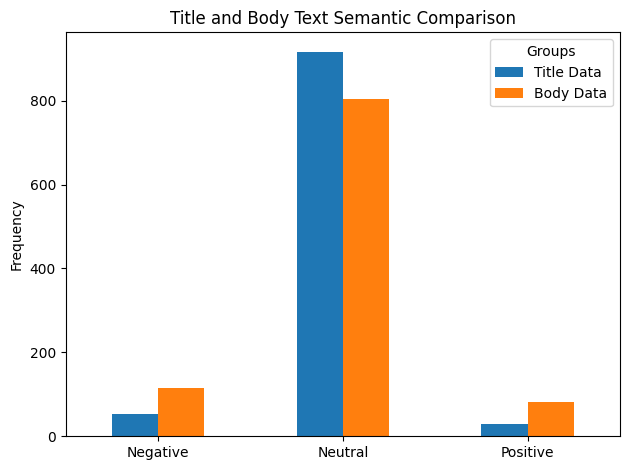

In [ ]:
sentiment_df = pd.DataFrame({"Title Data":count1, "Body Data":count2})
sentiment_df = sentiment_df.sort_index()

fig, ax = plt.subplots()
sentiment_df.plot(kind='bar', ax=ax)

ax.set_ylabel('Frequency')
ax.set_title('Title and Body Text Semantic Comparison')
ax.set_xticklabels(sentiment_df.index, rotation=0)  # Adjust rotation as needed
plt.legend(title='Groups')

plt.tight_layout()
plt.show()

In [ ]:
# the majority of these posts come out as neutral as the result of the financial sentiment being unaware of the specific vocabulary to WSB
# the results might be better if using a custom semantic vocabulary in addition
# the sentiment is the same after removing the stop words! success! more efficient!

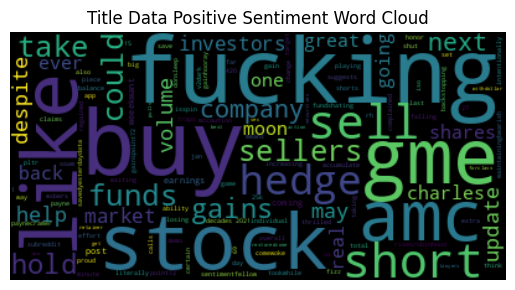

In [ ]:
words = ''
pos_title = title_data.loc[title_data['sentiment'] == "Positive", ['new_title']]
for i in pos_title['new_title']:
  words += i
words = words.split(" ")
d = {}
for i in words:
  d[i] = 0
for i in words:
  d[i] += 1
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.title("Title Data Positive Sentiment Word Cloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

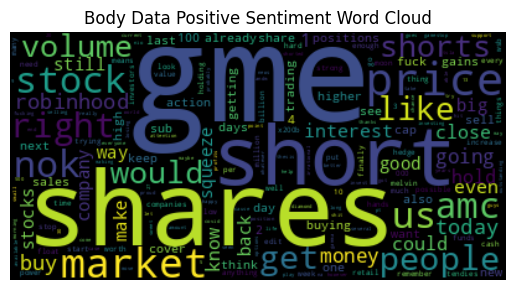

In [ ]:
words = ''
pos_title = body_data.loc[body_data['sentiment'] == "Positive", ['new_body']]
for i in pos_title['new_body']:
  words += i
words = words.split(" ")
d = {}
for i in words:
  d[i] = 0
for i in words:
  d[i] += 1
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.title("Body Data Positive Sentiment Word Cloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

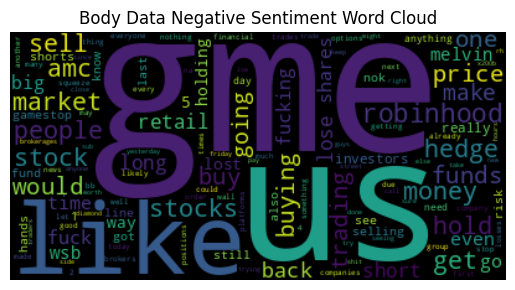

In [ ]:
words = ''
pos_title = body_data.loc[body_data['sentiment'] == "Negative", ['new_body']]
for i in pos_title['new_body']:
  words += i
words = words.split(" ")
d = {}
for i in words:
  d[i] = 0
for i in words:
  d[i] += 1
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.title("Body Data Negative Sentiment Word Cloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

By comparison of these two data frequency word clouds we can identify both polarising and common themes among the two. There are a number of named features such as GME, robinhood, and country names alike between the two which incentivises up to run a feature extraction on this data to derive more meaning from this data.

There is noticable difference in the words used in titles and body of positively semantic data

# Feature Extraction

In [ ]:
# both naive and named entity extraction
# get stock tickers from title and body
# use financial markets database

In [ ]:
title_data.head()

,index,title,timestamp,new_title,sentiment
0,0,itnot about the money itabout sendingmessage,2021-01-28,itnot money itabout sendingmessage,Neutral
1,1,math professor scott steiner says the numbers ...,2021-01-28,math professor scott steiner says numbers spel...,Negative
2,2,exit the system,2021-01-28,exit system,Neutral
3,3,new sec filing for gme can someone less retard...,2021-01-28,new sec filing gme someone less retarded pleas...,Neutral
4,4,not to distract from gme just thought our amc ...,2021-01-28,distract gme thought amc brothers aware,Neutral


In [ ]:
body_data.head()

,index,body,timestamp,new_body,sentiment
0,2,the ceo of nasdaq pushed to halt trading to gi...,2021-01-28,ceo nasdaq pushed halt trading give investorsc...,Neutral
1,6,hedgefund whales are spreading disinfo saying ...,2021-01-28,hedgefund whales spreading disinfo saying frid...,Negative
2,7,life isnfair my mother always told me that whe...,2021-01-28,life isnfair mother always told whenwould comp...,Neutral
3,10,i believe right now is one of those rare oppor...,2021-01-28,believe right one rare opportunities help good...,Positive
4,12,you guys are champs gme who would have thought...,2021-01-28,guys champs gme would thoughtbunch crazy retar...,Neutral


In [ ]:
# create a column of company tickers referenced
# create a column of company market value at time of post

# Financial Market Comparison

In [ ]:
# get current market open value of the stock
# implement time series analysis of stock
# will combine the title and body datasets

# maybe the posting time of the reddit post has significance to during markets open or close

In [97]:
msft = yf.Ticker("GME")
hist = msft.history(start="2021-01-01", end="2021-05-01", interval="1d")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,4.7500,4.7750,4.2875,4.3125,40090000,0.0,0.0
2021-01-05 00:00:00-05:00,4.3375,4.5200,4.3075,4.3425,19846000,0.0,0.0
2021-01-06 00:00:00-05:00,4.3350,4.7450,4.3325,4.5900,24224800,0.0,0.0
2021-01-07 00:00:00-05:00,4.6175,4.8625,4.5050,4.5200,24517200,0.0,0.0
2021-01-08 00:00:00-05:00,4.5450,4.5750,4.2700,4.4225,25928000,0.0,0.0


In [40]:
more_data = yf.download("TSLA NVDA AMD",
                        start="2021-01-01",
                        end="2021-05-01",
                        interval="1d",
                        group_by="tickers")

nvda = more_data['NVDA']['Open']
tsla = more_data['TSLA']['Open']
amd = more_data['AMD']['Open']
all_open = pd.DataFrame({"NVDA":nvda, "TSLA":tsla, "AMD":amd})

more_data.head(1)

[*********************100%%**********************]  3 of 3 completed


Ticker            NVDA                                                         \
Price             Open        High      Low       Close   Adj Close    Volume   
Date                                                                            
2021-01-04  131.042496  136.524994  129.625  131.134995  130.840134  56064000   

Ticker            TSLA                                                 \
Price             Open       High         Low       Close   Adj Close   
Date                                                                    
2021-01-04  239.820007  248.16333  239.063339  243.256668  243.256668   

Ticker                       AMD                                              \
Price          Volume       Open       High        Low      Close  Adj Close   
Date                                                                           
2021-01-04  145914600  92.110001  96.059998  90.919998  92.300003  92.300003   

Ticker                
Price         Volume  
Date                  
2021-01-04  51802600

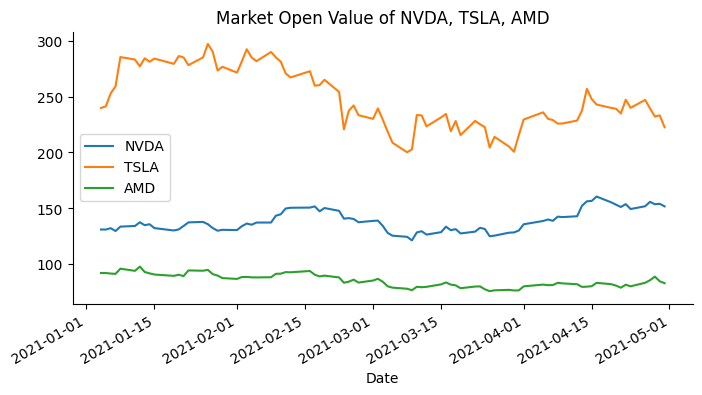

In [22]:
all_open.plot(kind='line', figsize=(8, 4), title='Market Open Value of NVDA, TSLA, AMD')
plt.gca().spines[['top', 'right']].set_visible(False)

In [67]:
# get dataset of tickers
tickers = pd.read_csv("MERGED.csv")
tickers = tickers.drop_duplicates(subset=["Symbol"])
tickers.head()

,Symbol,Name
0,AAIT,iShares MSCI All Country Asia Information Tech...
1,AAL,"American Airlines Group, Inc."
2,AAME,Atlantic American Corporation
3,AAOI,"Applied Optoelectronics, Inc."
4,AAON,"AAON, Inc."


In [104]:
post = "gamestop"

stock = tickers.loc[tickers['Name'] == "Gamestop Corporation Common Stock", ['Symbol','Name']]
stock = stock.reset_index(drop=True)
stock_name = str(stock['Name'][0]).lower().split(" ")

if post in stock_name:
  result = yf.Ticker(stock['Symbol'][0])
  hist = result.history(start = "2024-01-01", interval="1d")

hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00-05:00,17.250000,17.600000,16.580000,16.670000,4428000,0.0,0.0
2024-01-03 00:00:00-05:00,16.299999,16.830000,15.900000,16.690001,4193600,0.0,0.0
2024-01-04 00:00:00-05:00,16.510000,16.750000,16.309999,16.360001,2671500,0.0,0.0
2024-01-05 00:00:00-05:00,16.160000,16.520000,15.960000,15.960000,2615700,0.0,0.0
2024-01-08 00:00:00-05:00,15.780000,16.120001,15.700000,15.790000,3031100,0.0,0.0


#**IDEAS and PLAN**
## Developing an algorithmic trading model from the wallstreetbets post semantics to generate a positive return in the stock market.

## Compare this against historical stock values and current as two different scenarios

## The determined success of this will comment on the effectivenes of the wallstreetbets portfolio and therefore indicate if institutional investors should pay greater attention to online retail investor communities

## *its worthy finding any financial quant paper which factor in what they look for when assesing retail investors any if theres some sort of criteria to pay attention towards

## is the score of the post correlated with the future direction of the stock